In [16]:
import torch
from tfrecord.torch.dataset import MultiTFRecordDataset
import matplotlib.pyplot as plt
import pandas as pd

import torch.nn.functional as F
import torch.nn as nn

import torch.optim as optim
from tqdm import tqdm
import copy

from utils import load
from attrdict import AttrDict
import json

### Load dataset and metadata

In [57]:
lf_meta = pd.read_csv('fuel_autoencoder_conus/landfire_metadata.csv')
lf_meta.drop(index = 0,inplace= True)

landfire_fuel_classes = dict(zip(lf_meta['VALUE'],lf_meta['FBFM40']))

kys = list(landfire_fuel_classes.keys())
fuel_classes = {i:landfire_fuel_classes[x] for i,x in enumerate(kys)}
fuel_class_map = {x:i for i,x in enumerate(kys)}

In [58]:
viz = {row['FBFM40']:(row['R'],row['G'],row['B']) for i,row in lf_meta.iterrows()}

In [59]:
modes = ['train','test','val']
tf_patterns = {
    'train':('conus_dataset/fbfm_conus_train{}.tfrecord','conus_dataset/fbfm_conus_train{}.tfindex'),
    'test':('conus_dataset/fbfm_conus_test{}.tfrecord','conus_dataset/fbfm_conus_test{}.tfindex'),
    'val':('conus_dataset/fbfm_conus_val{}.tfrecord','conus_dataset/fbfm_conus_val{}.tfindex'),
}
data_loaders = {}
for mode in modes:
    print("Loading",mode,"data")
    tfrecord_pattern = tf_patterns[mode][0]
    index_pattern = tf_patterns[mode][1]
    description = {"fbfm": "float"}
    unsplit = {'0':0.5,'1':0.5}
    dataset = MultiTFRecordDataset(tfrecord_pattern, index_pattern,unsplit, description,infinite = False)
    loader = torch.utils.data.DataLoader(dataset, batch_size=2048)
    data_loaders[mode] = loader

train
test
val


### data processing funcs

In [60]:
def replace_categories(value):
    try:
        return fuel_class_map[value]
    except KeyError:
        return float('nan')

def get_pcts(arr): # takes (B,H,W) array
    B,H,W = arr.shape
    n_cats = len(kys)
    res = torch.zeros((B,n_cats))
    for i,img in enumerate(arr):
        for k,cat in enumerate(kys):
            res[i,k] = torch.sum(arr[i] == cat).item()/(H*W)
    return res

def process_batch(data_batch,onehot = False):
    data = data_batch['fbfm'].clone()
    data = data.reshape((data.shape[0],16,16))
    labels = get_pcts(data)
    data.apply_(replace_categories)
    if onehot:
        data = F.one_hot(data.long(),num_classes = len(kys)).float()
    return data,labels

### Training loop

In [24]:
run_name = 'example'

#### Define and load the model from its configuration file

In [25]:
config = AttrDict({
    "conv_channels":[32,32, 32],
    "kernel_sizes":[3, 3,3],
    "strides":[1, 1,1],
    "paddings":[1, 1,1],
    "pooling":'max',
    "pool_kernels":[2, 2,2],
    "encoder_hidden_dims":[32,16,8],
    "latent_dim":3,
    "decoder_hidden_dims":[8,16,32],
    "weights_seed":123,
    "learning_rate":1e-4,
    'n_epochs':15,
})

model_config_file = osp.join('fuel_autoencoder_config.py')
autoencoder,name = load(model_config_file,config)

with open(f'models/{run_name}.json','w') as json_file:
    json.dump(config,json_file)

Loading 'fuel_autoencoder_config' from /Users/gorg/Documents/ndws/fuel_embedding/fuel_autoencoder_config.py


In [26]:
autoencoder

fuel_autoencoder(
  (encoder): Encoder(
    (activation): ReLU()
    (conv_layers): ModuleList(
      (0): Conv2d(45, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1-2): 2 x Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (pool_layers): ModuleList(
      (0-2): 3 x MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc_layers): ModuleList(
      (0): Linear(in_features=128, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=16, bias=True)
      (2): Linear(in_features=16, out_features=8, bias=True)
      (3): Linear(in_features=8, out_features=3, bias=True)
    )
    (fc_batch_norms): ModuleList(
      (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (decoder):

### Model training

In [88]:
# Define the optimizer
# autoencoder.load_state_dict(best_model_wts)

optimizer = optim.AdamW(autoencoder.parameters(), lr=config['learning_rate'])

# Define the loss function
criterion = nn.KLDivLoss(reduction='batchmean')

train_losses = []
val_losses = []

# Number of epochs
num_epochs = config['n_epochs']

# Device configuration
device = torch.device('mps')
autoencoder.to(device)

best_model_wts = copy.deepcopy(autoencoder.state_dict())
best_loss = float('inf')

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            autoencoder.train()  # Set model to training mode
        else:
            autoencoder.eval()   # Set model to evaluate mode

        running_loss = 0.0

        # Iterate over data
        with tqdm(data_loaders[phase], unit="batch") as tepoch:
            for batch in tepoch:
                tepoch.set_description(f"{phase.capitalize()} Epoch {epoch+1}")

                inputs,targets = process_batch(batch,onehot = True)
                
                inputs = inputs.to(device)  # Shape: (B, 16, 16, 45)
                targets = targets.to(device)  # Shape: (B, 45)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = autoencoder(inputs)  # Shape: (B, 45)

                    # Apply log_softmax to outputs
                    log_probs = F.log_softmax(outputs, dim=-1)

                    # Compute loss
                    loss = criterion(log_probs, targets)

                    # Backward pass and optimization
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                tepoch.set_postfix(loss=loss.item())

        epoch_loss = running_loss / 911360 # batch 2048 * 445 batches = 911360 

        if phase == 'train':
            train_losses.append(epoch_loss)
        else:
            val_losses.append(epoch_loss)

            # Deep copy the model if it has better validation loss
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(autoencoder.state_dict())

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}')

print('Training complete')
print(f'Best Validation Loss: {best_loss:.4f}')

# Load best model weights
autoencoder.load_state_dict(best_model_wts)

Epoch 1/15
----------


Train Epoch 1: : 1686batch [39:15,  1.40s/batch, loss=3.08] 


Train Loss: 4.9810


Val Epoch 1: : 505batch [11:23,  1.35s/batch, loss=0.893]


Val Loss: 1.0495
Epoch 2/15
----------


Train Epoch 2: : 1686batch [38:32,  1.37s/batch, loss=2.85] 


Train Loss: 2.8075


Val Epoch 2: : 505batch [11:25,  1.36s/batch, loss=0.793]


Val Loss: 0.9351
Epoch 3/15
----------


Train Epoch 3: : 1686batch [38:32,  1.37s/batch, loss=2.27] 


Train Loss: 2.2137


Val Epoch 3: : 505batch [11:28,  1.36s/batch, loss=0.745]


Val Loss: 0.8504
Epoch 4/15
----------


Train Epoch 4: : 1686batch [38:55,  1.39s/batch, loss=2.57] 


Train Loss: 1.9244


Val Epoch 4: : 505batch [11:31,  1.37s/batch, loss=0.719]


Val Loss: 0.8289
Epoch 5/15
----------


Train Epoch 5: : 1686batch [38:49,  1.38s/batch, loss=2.79] 


Train Loss: 1.7197


Val Epoch 5: : 505batch [11:25,  1.36s/batch, loss=0.769]


Val Loss: 0.8974
Epoch 6/15
----------


Train Epoch 6: : 1686batch [38:28,  1.37s/batch, loss=3.18] 


Train Loss: 1.8283


Val Epoch 6: : 505batch [11:23,  1.35s/batch, loss=0.863]


Val Loss: 0.9703
Epoch 7/15
----------


Train Epoch 7: : 1686batch [39:12,  1.40s/batch, loss=1.45] 


Train Loss: 1.9596


Val Epoch 7: : 505batch [11:30,  1.37s/batch, loss=0.671]


Val Loss: 0.7571
Epoch 8/15
----------


Train Epoch 8: : 1686batch [38:23,  1.37s/batch, loss=2.01] 


Train Loss: 1.6737


Val Epoch 8: : 505batch [11:29,  1.37s/batch, loss=0.601]


Val Loss: 0.6928
Epoch 9/15
----------


Train Epoch 9: : 1686batch [39:26,  1.40s/batch, loss=1.59] 


Train Loss: 1.5487


Val Epoch 9: : 505batch [11:25,  1.36s/batch, loss=0.743]


Val Loss: 0.8326
Epoch 10/15
----------


Train Epoch 10: : 1686batch [38:34,  1.37s/batch, loss=3.2]  


Train Loss: 1.5335


Val Epoch 10: : 505batch [11:21,  1.35s/batch, loss=0.622]


Val Loss: 0.7250
Epoch 11/15
----------


Train Epoch 11: : 1686batch [38:25,  1.37s/batch, loss=3.52] 


Train Loss: 1.4702


Val Epoch 11: : 505batch [11:24,  1.35s/batch, loss=0.616]


Val Loss: 0.6884
Epoch 12/15
----------


Train Epoch 12: : 1686batch [38:23,  1.37s/batch, loss=2.14] 


Train Loss: 1.4242


Val Epoch 12: : 505batch [11:24,  1.36s/batch, loss=0.556]


Val Loss: 0.6768
Epoch 13/15
----------


Train Epoch 13: : 1686batch [38:29,  1.37s/batch, loss=3.47] 


Train Loss: 1.3682


Val Epoch 13: : 505batch [11:24,  1.35s/batch, loss=0.803]


Val Loss: 0.8734
Epoch 14/15
----------


Train Epoch 14: : 1686batch [38:24,  1.37s/batch, loss=3.66] 


Train Loss: 1.4195


Val Epoch 14: : 505batch [11:23,  1.35s/batch, loss=0.614]


Val Loss: 0.6725
Epoch 15/15
----------


Train Epoch 15: : 1686batch [38:24,  1.37s/batch, loss=2.56] 


Train Loss: 1.3577


Val Epoch 15: : 505batch [11:20,  1.35s/batch, loss=0.56] 

Val Loss: 0.6509
Training complete
Best Validation Loss: 0.6509


<All keys matched successfully>

In [89]:
torch.save(best_model_wts,f'models/{run_name}.pth')

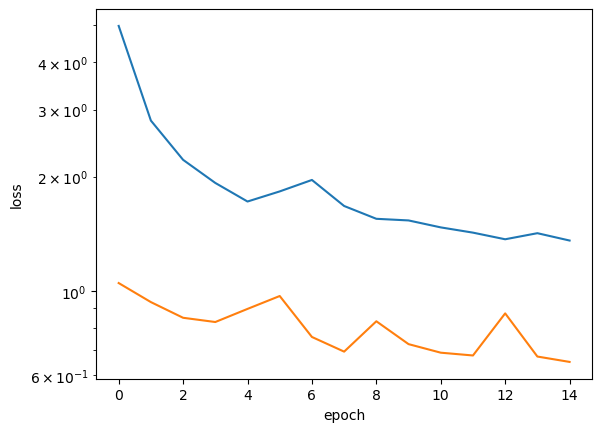

In [92]:
plt.plot(train_losses,label = 'train')
plt.plot(val_losses,label = 'test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')